## 환경 설정

In [127]:
import torch
from torchvision import transforms
import torchvision
import PIL
import matplotlib.pyplot as plt
import pathlib
import os
import pickle
import warnings
import copy
import numpy as np
import math
warnings.filterwarnings('ignore')

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
%cd /content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify

/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify


In [130]:
!pip install ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
import ninja

In [132]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


## Model load

In [133]:
model_list=list(pathlib.Path('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/pretrained').glob('*.pkl'))
model_list

[PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/pretrained/ffhq.pkl'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/pretrained/metfaces.pkl')]

In [134]:
with open(model_list[0], 'rb') as f:
    G = pickle.load(f)['G_ema'].requires_grad_(False).to(device)#.cuda()  # torch.nn.Module
    
G=G.eval()

## Random Test

In [ ]:
#from torchvision.utils import save_image
#save_image(img_2[0],'/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/images/normal_face/kid.png')

In [143]:
#make random z vecotrs
z_1 = torch.randn([1, G.z_dim],device=device)
z_2 = torch.randn([1, G.z_dim],device=device)
c = None

In [144]:
w_1 = G.mapping(z_1,c,truncation_psi=0.5, truncation_cutoff=8)
w_2 = G.mapping(z_2,c,truncation_psi=0.5, truncation_cutoff=8)
img_1 = G.synthesis(w_1, noise_mode='const', force_fp32=True)
img_2 = G.synthesis(w_2, noise_mode='const', force_fp32=True)

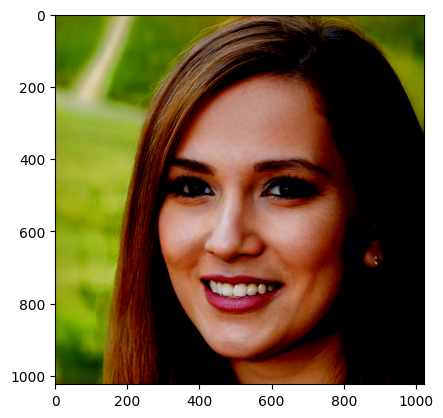

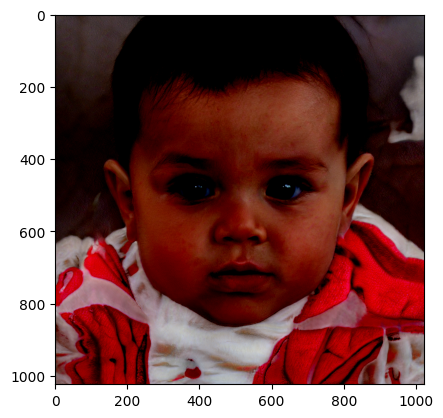

In [145]:
img_1=img_1.to('cpu')
plt.imshow(img_1[0].permute(1,2,0))
plt.show()
img_2=img_2.to('cpu')
plt.imshow(img_2[0].permute(1,2,0))
plt.show()

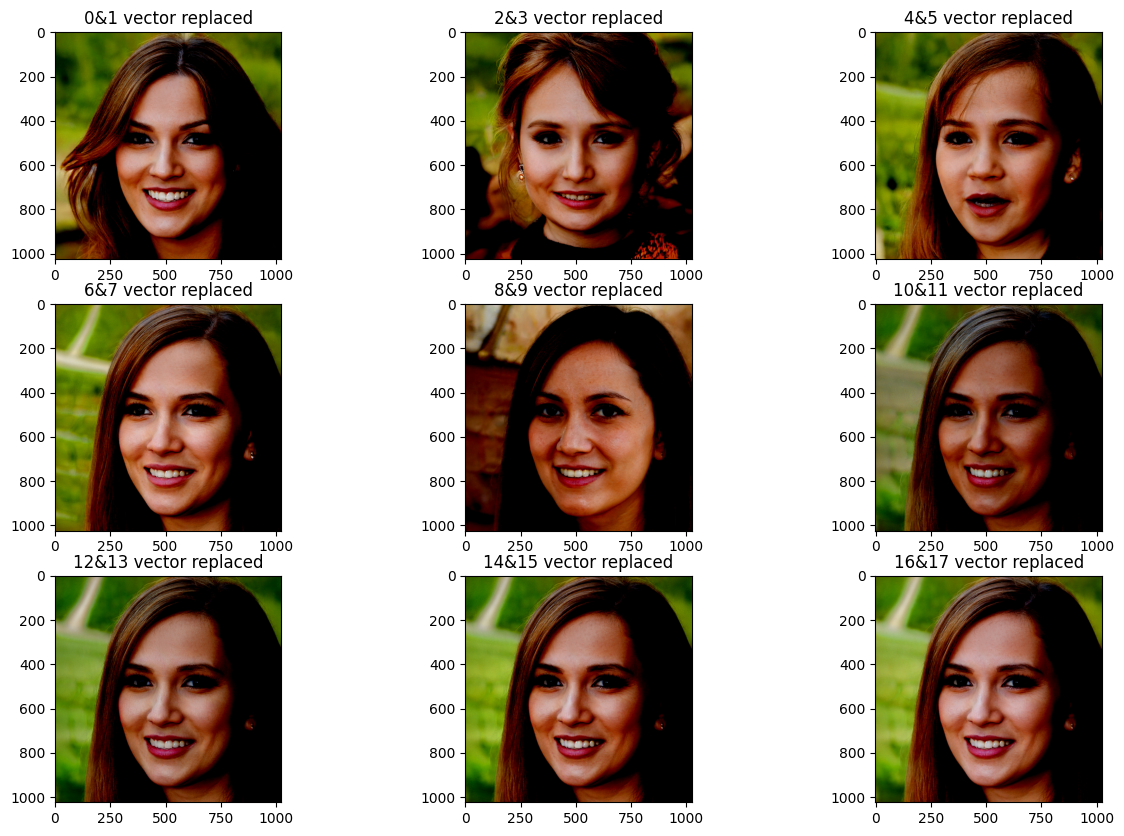

In [146]:
##벡터 2개씩 바꾸기
fig,axes=plt.subplots(3,3,figsize=(15,10))
for i,ax in zip(range(0,18,2),axes.ravel()):
  w_blend=w_1.clone() #w_1 기준으로 변환
  w_blend[0][i:i+2]=w_2[0][i:i+2]
  img_blend = G.synthesis(w_blend, noise_mode='const', force_fp32=True)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0].permute(1,2,0))
  ax.set_title('{}&{} vector replaced'.format(i,i+1))

In [147]:
## 0부터 1개씩 누적 변경
fig,axes=plt.subplots(6,3,figsize=(15,30))
for i,ax in zip(range(18),axes.ravel()):
  w_blend=w_1.clone()
  w_blend[0][0:i]=w_2[0][0:i]
  img_blend = G.synthesis(w_blend, noise_mode='const', force_fp32=True)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0].permute(1,2,0))
  ax.set_title('0~{} vector replaced'.format(i))

Output hidden; open in https://colab.research.google.com to view.

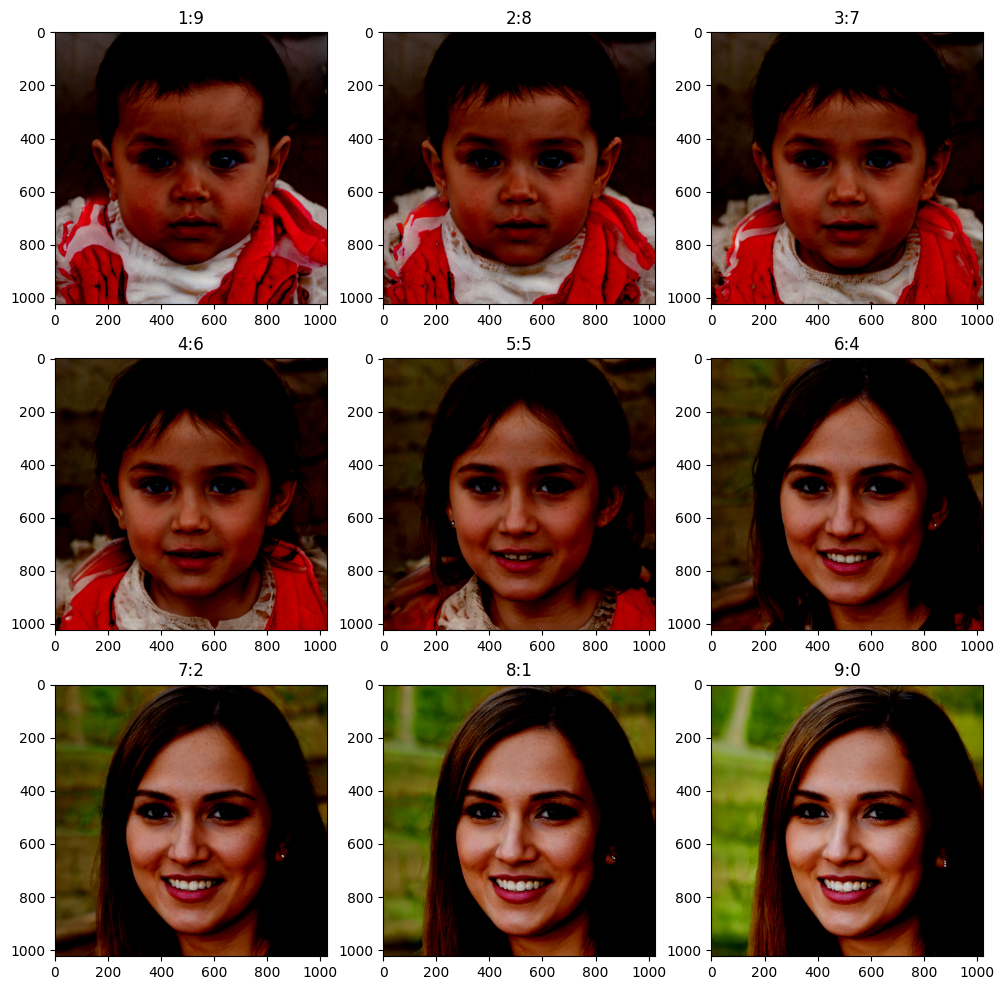

In [148]:
##선형보간
fig,axes=plt.subplots(3,3,figsize=(12,12))
for rate,ax in zip(np.arange(0.1,1,0.1),axes.ravel()):
  w_blend=rate*w_1+(1-rate)*w_2
  img_blend = G.synthesis(w_blend, noise_mode='const', force_fp32=True)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0].permute(1,2,0))
  ax.set_title('{}:{}'.format(int(rate*10),int((1-rate)*10)))

## FFHQ Dataset preprocessing

In [149]:
face_file_path='./images/normal_face/rose2.jpeg'

- landmark detection

In [150]:
from PIL import Image 
from IPython.display import display

def display_image_from_file(image_name):
  # Reference: https://stackoverflow.com/a/50723518
  
  image_content = Image.open(image_name)
  display(image_content)

  return

def display_image_from_array(array):
  # Reference: https://gist.github.com/kylemcdonald/2f1b9a255993bf9b2629

  image_content = Image.fromarray(array)
  display(image_content) 

  return    
     

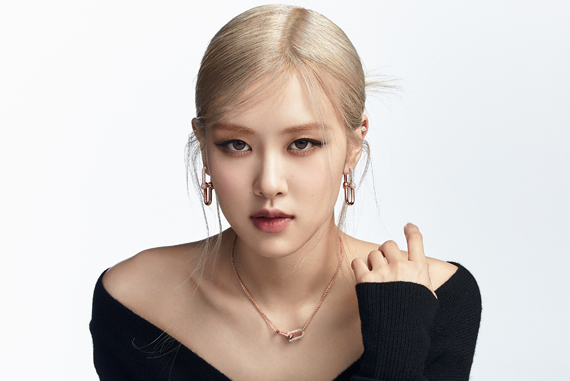

In [151]:
display_image_from_file(face_file_path)

In [152]:
import sys
import os
import dlib
import glob

In [153]:
def detect_face_landmarks(face_file_path=None,
                          predictor_path=None,
                          img=None):
  # References:
  # -   http://dlib.net/face_landmark_detection.py.html
  # -   http://dlib.net/face_alignment.py.html

  if predictor_path is None:
    predictor_path = './shape_predictor_68_face_landmarks.dat'

  # Load all the models we need: a detector to find the faces, a shape predictor
  # to find face landmarks so we can precisely localize the face
  detector = dlib.get_frontal_face_detector()
  shape_predictor = dlib.shape_predictor(predictor_path)

  if img is None:
    # Load the image using Dlib
    print("Processing file: {}".format(face_file_path))
    img = dlib.load_rgb_image(face_file_path)

  shapes = list()

  # Ask the detector to find the bounding boxes of each face. The 1 in the
  # second argument indicates that we should upsample the image 1 time. This
  # will make everything bigger and allow us to detect more faces.
  dets = detector(img, 1)
    
  num_faces = len(dets)
  print("Number of faces detected: {}".format(num_faces))

  # Find the face landmarks we need to do the alignment.
  faces = dlib.full_object_detections()
  for d in dets:
      print("Left: {} Top: {} Right: {} Bottom: {}".format(
          d.left(), d.top(), d.right(), d.bottom()
      ))

      shape = shape_predictor(img, d)
      faces.append(shape)

  return faces

In [154]:
faces = detect_face_landmarks(face_file_path=face_file_path)

Processing file: ./images/normal_face/rose2.jpeg
Number of faces detected: 1
Left: 201 Top: 98 Right: 356 Bottom: 253


In [155]:
import collections

plot_style = dict(marker='o',
                  markersize=4,
                  linestyle='-',
                  lw=2)

pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
pred_types = {'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
              'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
              'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
              'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
              'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
              'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
              'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
              'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
              'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
              }

In [156]:
import matplotlib.pyplot as plt

def display_landmarks_raw(input_img, preds=None, fig_size=None):
  # This is a raw copy from:
  # https://github.com/1adrianb/face-alignment/blob/master/examples/detect_landmarks_in_image.py

  if fig_size is None:
    fig_size = plt.figaspect(.5)

  fig = plt.figure(figsize=fig_size)
  ax = fig.add_subplot(1, 1, 1) # only display one image
  ax.imshow(input_img)

  if preds is not None:
    for pred_type in pred_types.values():
        ax.plot(preds[pred_type.slice, 0],
                preds[pred_type.slice, 1],
                color=pred_type.color, **plot_style)

  ax.axis('off')

  return

In [157]:
from skimage import io

def display_landmarks(image_name, 
                      dlib_output_faces=None, 
                      face_no=0,
                      fig_size=None):
  
  if fig_size is None:
    fig_size = [15, 15]

  input_img = io.imread(image_name)

  if dlib_output_faces is None:
    dlib_output_faces = detect_face_landmarks(face_file_path=image_name,
                                              img=input_img)

  try:
    current_face = dlib_output_faces[face_no]

  except IndexError:
    current_face = None

    print('No face found for index n°{} (max={}).'.format(
        face_no, 
        len(dlib_output_faces)-1,
        ))

  if current_face is None:
    preds = None
  else:
    face_parts = current_face.parts()
    
    preds = np.array([
                      [v.x, v.y] 
                      for v in face_parts
                      ])    
    
  display_landmarks_raw(input_img=input_img, 
                        preds=preds,
                        fig_size=fig_size)  

  return

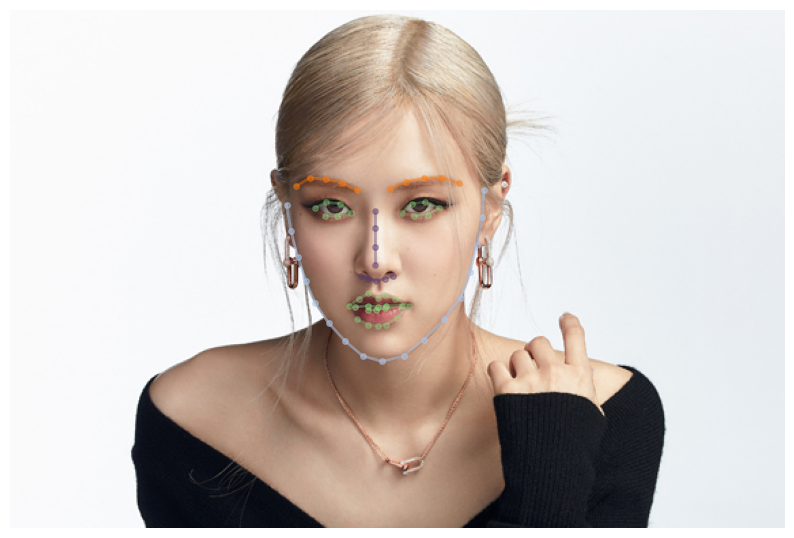

In [158]:
face_no=0
fig_size=[10,10]

display_landmarks(image_name=face_file_path,
                  dlib_output_faces=faces,
                  face_no=face_no,
                  fig_size=fig_size)

- align no.1

In [ ]:
img = dlib.load_rgb_image(face_file_path)

thumbnail_size = 512
thumbnails = dlib.get_face_chips(img, faces, size=thumbnail_size)

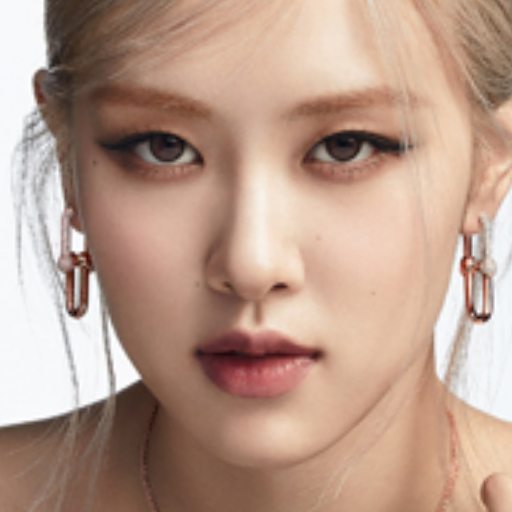

In [ ]:
display_image_from_array(thumbnails[0])

- align no.2

In [159]:
import sys
import requests
import html
import hashlib
import PIL.ImageFile
import scipy.ndimage
import threading
import queue
import time
import json
import uuid
import argparse
import itertools
import shutil
from collections import OrderedDict, defaultdict

# Reference: https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py

def recreate_aligned_images(json_data, 
                            dst_dir='realign1024x1024',
                            output_size=1024, 
                            transform_size=4096, 
                            enable_padding=True):
    print('Recreating aligned images...')
    if dst_dir:
        os.makedirs(dst_dir, exist_ok=True)

    for item_idx, item in enumerate(json_data.values()):
        print('\r%d / %d ... ' % (item_idx, len(json_data)), end='', flush=True)

        # Parse landmarks.
        # pylint: disable=unused-variable
        lm = np.array(item['in_the_wild']['face_landmarks'])
        lm_chin          = lm[0  : 17]  # left-right
        lm_eyebrow_left  = lm[17 : 22]  # left-right
        lm_eyebrow_right = lm[22 : 27]  # left-right
        lm_nose          = lm[27 : 31]  # top-down
        lm_nostrils      = lm[31 : 36]  # top-down
        lm_eye_left      = lm[36 : 42]  # left-clockwise
        lm_eye_right     = lm[42 : 48]  # left-clockwise
        lm_mouth_outer   = lm[48 : 60]  # left-clockwise
        lm_mouth_inner   = lm[60 : 68]  # left-clockwise

        # Calculate auxiliary vectors.
        eye_left     = np.mean(lm_eye_left, axis=0)
        eye_right    = np.mean(lm_eye_right, axis=0)
        eye_avg      = (eye_left + eye_right) * 0.5
        eye_to_eye   = eye_right - eye_left
        mouth_left   = lm_mouth_outer[0]
        mouth_right  = lm_mouth_outer[6]
        mouth_avg    = (mouth_left + mouth_right) * 0.5
        eye_to_mouth = mouth_avg - eye_avg

        # Choose oriented crop rectangle.
        print(eye_to_mouth.shape)
        x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
        x /= np.hypot(*x)
        x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
        y = np.flipud(x) * [-1, 1]
        c = eye_avg + eye_to_mouth * 0.1
        quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
        qsize = np.hypot(*x) * 2

        # Load in-the-wild image.
        src_file = item['in_the_wild']['file_path']
        img = PIL.Image.open(src_file)

        # Shrink.
        shrink = int(np.floor(qsize / output_size * 0.5))
        if shrink > 1:
            rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
            img = img.resize(rsize, PIL.Image.ANTIALIAS)
            quad /= shrink
            qsize /= shrink

        # Crop.
        border = max(int(np.rint(qsize * 0.1)), 3)
        crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
        if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
            img = img.crop(crop)
            quad -= crop[0:2]

        # Pad.
        pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
        if enable_padding and max(pad) > border - 4:
            pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
            img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
            h, w, _ = img.shape
            y, x, _ = np.ogrid[:h, :w, :1]
            mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
            blur = qsize * 0.02
            img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
            img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
            img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
            quad += pad[:2]

        # Transform.
        img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
        if output_size < transform_size:
            img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

        # Save aligned image.
        dst_subdir = os.path.join(dst_dir, '%05d' % (item_idx - item_idx % 1000))
        os.makedirs(dst_subdir, exist_ok=True)
        img.save(os.path.join(dst_subdir, '%05d.png' % item_idx))

    # All done.
    print('\r%d / %d ... done' % (len(json_data), len(json_data)))

    return

In [160]:

# The first face which is detected:
# NB: we assume that there is exactly one face per picture!
f = faces[0]

parts = f.parts()

num_face_landmarks=68

v = np.zeros(shape=(num_face_landmarks, 2))
for k, e in enumerate(parts):
  v[k, :] = [e.x, e.y]

In [161]:
json_data = dict()

item_idx = 0

json_data[item_idx] = dict()
json_data[item_idx]['in_the_wild'] = dict()
json_data[item_idx]['in_the_wild']['file_path'] = face_file_path
json_data[item_idx]['in_the_wild']['face_landmarks'] = v

In [162]:
recreate_aligned_images(json_data)

Recreating aligned images...
0 / 1 ... (2,)
1 / 1 ... done


In [163]:
face_file_path

'./images/normal_face/rose2.jpeg'

In [164]:
ffhq_aligned_image_name=face_file_path.split('/')[-1].split('.')[0]+'.jpg'
!cp './realign1024x1024/00000/00000.png' $ffhq_aligned_image_name

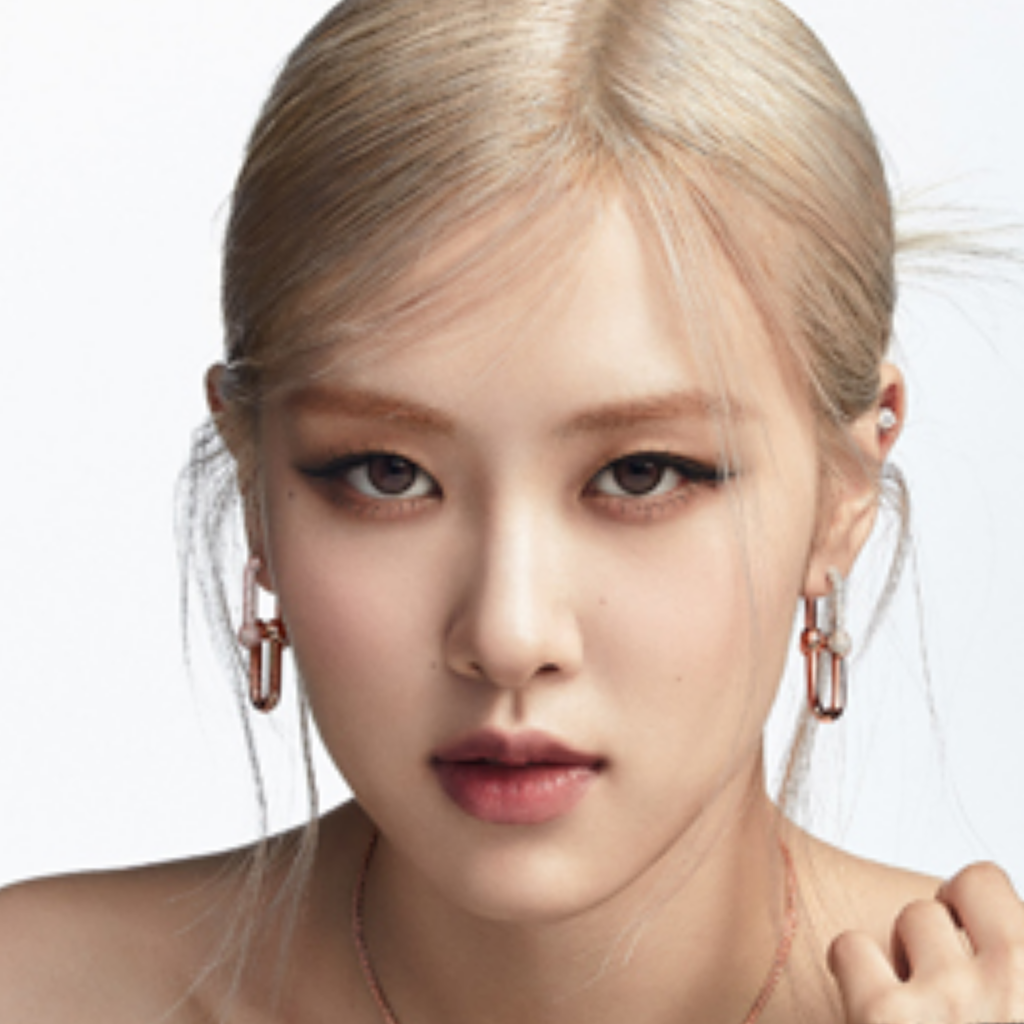

In [165]:
display_image_from_file(ffhq_aligned_image_name)

## project image to latent vector

In [ ]:
#click option
#('--network', 'network_pkl', help='Network pickle filename', required=True)
#('--target', 'target_fname', help='Target image file to project to', required=True, metavar='FILE')
#('--num-steps',              help='Number of optimization steps', type=int, default=1000, show_default=True)
#('--seed',                   help='Random seed', type=int, default=303, show_default=True)
#('--save-video',             help='Save an mp4 video of optimization progress', type=bool, default=True, show_default=True)
#('--outdir',                 help='Where to save the output images', required=True, metavar='DIR')
#('--verbose',                help='verbose', type=bool, default=True)
#('--extend',                help='Want to project with extended w(18vectors)', type=bool, default=False))

In [166]:
!python projector_custom.py --outdir=./out/rose2 --target=./realign1024x1024/00000/rose2.png --network=./pretrained/ffhq.pkl --save-video=False --verbose=True --extend=True --num-steps=5000

Loading networks from "./pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/5000: dist 0.81 loss 24567.48
step    2/5000: dist 0.83 loss 27640.80
step    3/5000: dist 0.86 loss 27544.86
step    4/5000: dist 0.80 loss 27353.40
step    5/5000: dist 0.83 loss 27069.78
step    6/5000: dist 0.77 loss 26698.23
step    7/5000: dist 0.86 loss 26243.84
step    8/5000: dist 0.78 loss 25711.86
step    9/5000: dist 0.81 loss 25109.07
step   10/5000: dist 0.76 loss 24442.59
step   11/5000: dist 0.79 loss 23719.22
step   12/5000: dist 0.87 loss 22944.29
step   13/

In [ ]:
!python projector_custom.py --outdir=./out/macron --target=./realign1024x1024/00000/macron.png --network=./pretrained/ffhq.pkl --save-video=False --verbose=True --extend=True --num-steps=5000

## Specified Image Blend

In [167]:
w_1=torch.Tensor(np.load('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/rose2/projected_w1.npz')['w'])
w_2=torch.Tensor(np.load('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/monalisa/projected_w1.npz')['w'])

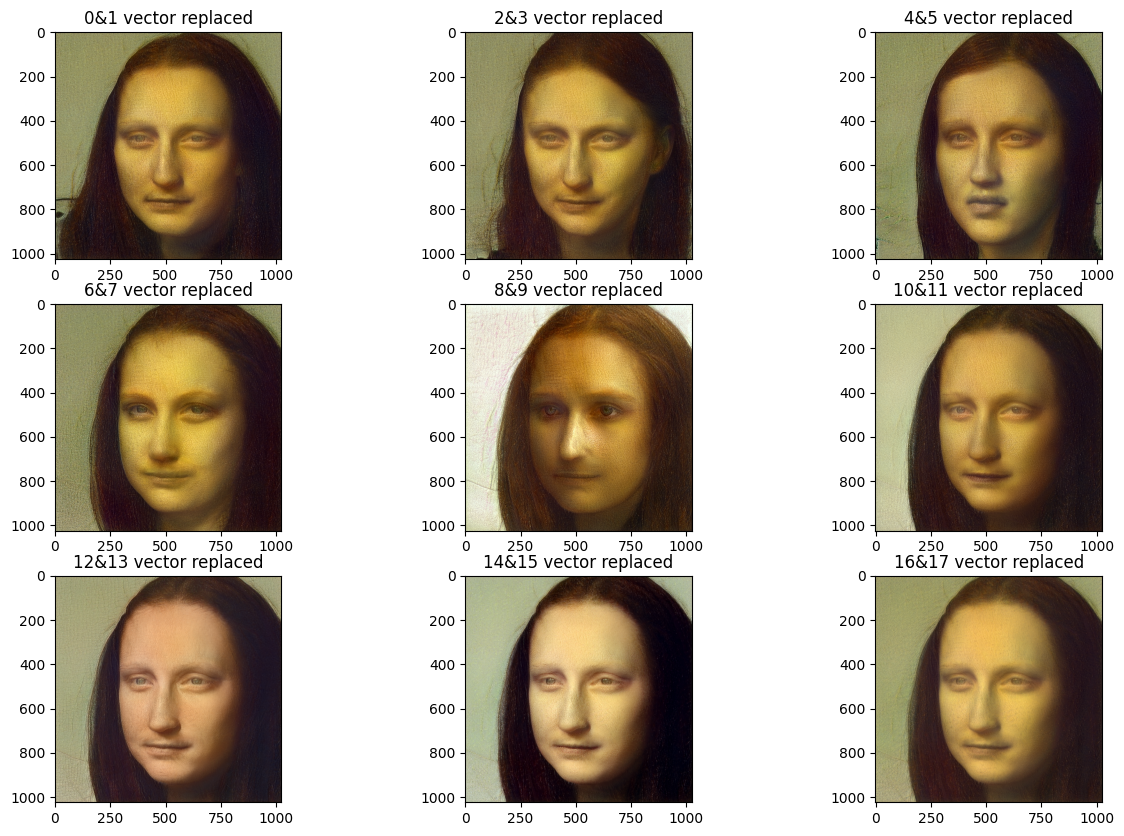

In [168]:
##벡터 2개씩 바꾸기
fig,axes=plt.subplots(3,3,figsize=(15,10))
for i,ax in zip(range(0,18,2),axes.ravel()):
  w_blend=w_2.clone()
  w_blend[0][i:i+2]=w_1[0][i:i+2]
  w_blend=w_blend.to(device)
  img_blend = G.synthesis(w_blend, noise_mode='const')
  img_blend = (img_blend.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0])
  ax.set_title('{}&{} vector replaced'.format(i,i+1))

In [169]:
## 0부터 1개씩 누적 변경
fig,axes=plt.subplots(6,3,figsize=(15,30))
for i,ax in zip(range(18),axes.ravel()):
  w_blend=w_2.clone()
  w_blend[0][0:i]=w_1[0][0:i]
  w_blend=w_blend.to(device)
  img_blend = G.synthesis(w_blend, noise_mode='const')
  img_blend = (img_blend.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0])
  ax.set_title('{}~{} vector replaced'.format(0,i))

Output hidden; open in https://colab.research.google.com to view.

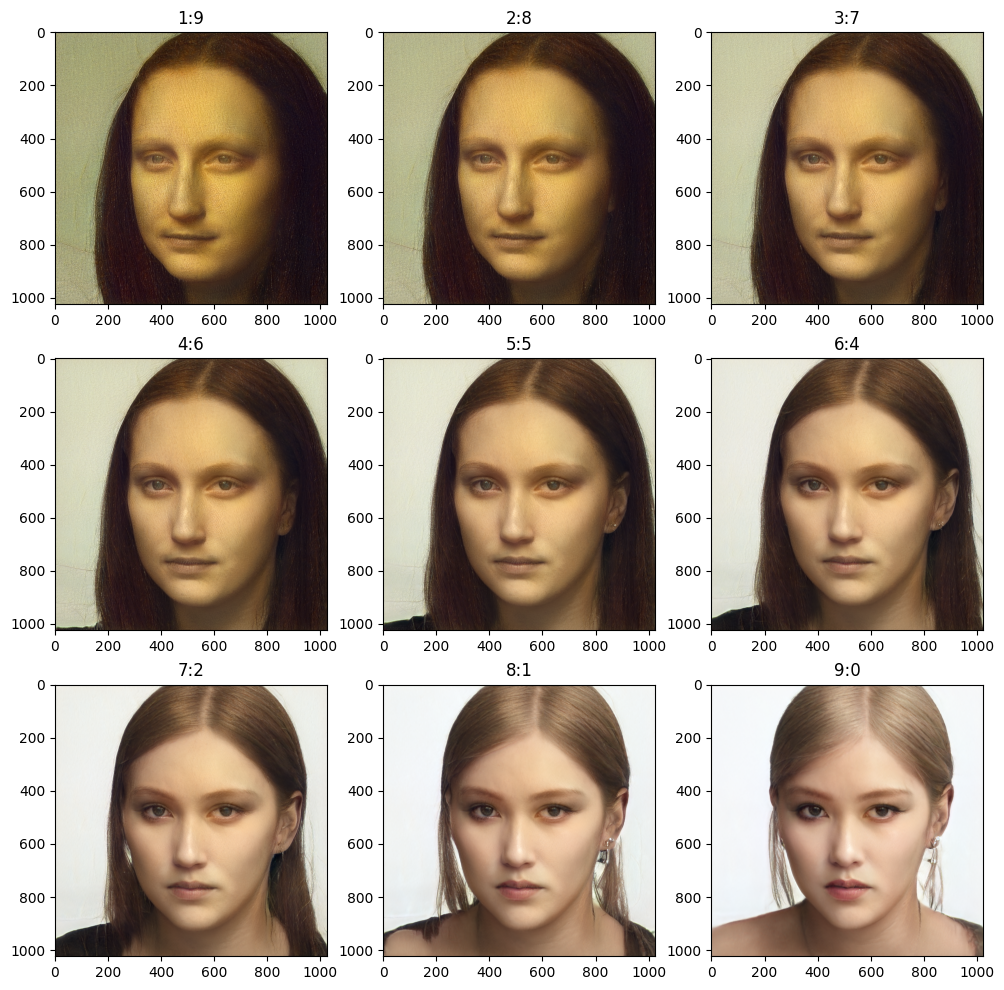

In [170]:
##선형보간
fig,axes=plt.subplots(3,3,figsize=(12,12))
for rate,ax in zip(np.arange(0.1,1,0.1),axes.ravel()):
  w_blend=rate*w_1+(1-rate)*w_2
  w_blend=w_blend.to(device)
  img_blend = G.synthesis(w_blend, noise_mode='const')
  img_blend = (img_blend.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0])
  ax.set_title('{}:{}'.format(int(rate*10),int((1-rate)*10)))

Text(0.5, 1.0, '0~7 vector replaced')

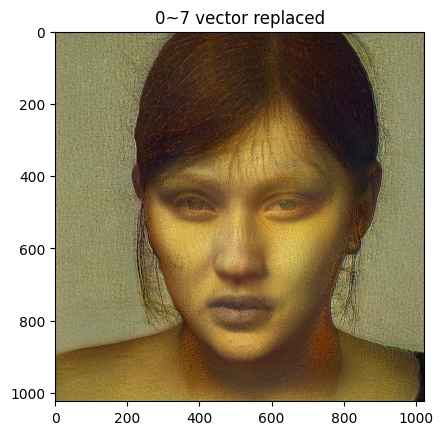

In [171]:
w_blend=w_2.clone()
w_blend[0][0:7]=w_1[0][0:7]
w_blend=w_blend.to(device)
img_blend = G.synthesis(w_blend, noise_mode='const')
img_blend = (img_blend.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
img_blend=img_blend.to('cpu')
plt.imshow(img_blend[0])
plt.title('{}~{} vector replaced'.format(0,7))

In [ ]:
#torchvision.utils.save_image(test,'/content/drive/MyDrive/StyleGAN/images/resized_tensor/rose2.png')

## G net with image mapped into latent vector

In [ ]:
with open(model_list[0], 'rb') as f:
    G = pickle.load(f)['G_ema'].requires_grad_(False).to(device)#.cuda()  # torch.nn.Module
    
G=G.eval()

(1, 18, 512)


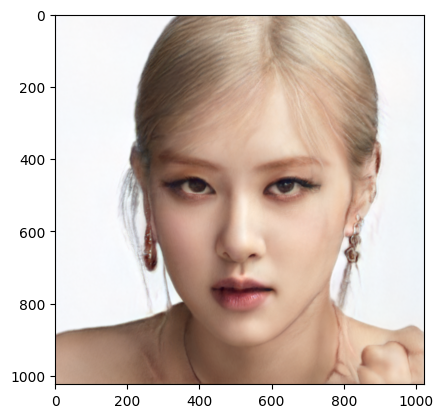

In [ ]:
projected_w='/content/drive/MyDrive/StyleGAN/out/rose2/projected_w18_5000.npz'

ws = np.load(projected_w)['w']
print(ws.shape)
ws = torch.tensor(ws, device=device) # pylint: disable=not-callable
assert ws.shape[1:] == (G.num_ws, G.w_dim)
for idx, w in enumerate(ws):
    img = G.synthesis(w.unsqueeze(0), noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8) #G로 생성하면 정규화돼서 나옴
    img=img.to('cpu')
    plt.imshow(img[0])

(1, 18, 512)


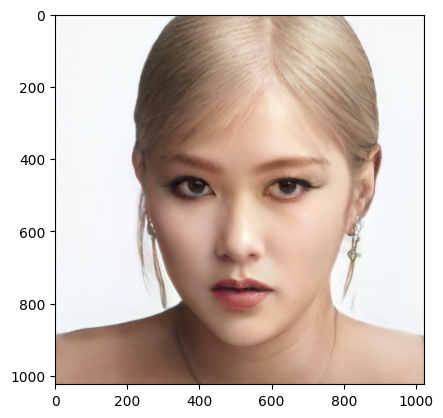

In [ ]:
projected_w='/content/drive/MyDrive/StyleGAN/out/rose2/projected_w1.npz'

ws = np.load(projected_w)['w']
print(ws.shape)
ws = torch.tensor(ws, device=device) # pylint: disable=not-callable
assert ws.shape[1:] == (G.num_ws, G.w_dim)
for idx, w in enumerate(ws):
    img = G.synthesis(w.unsqueeze(0), noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8) #G로 생성하면 정규화돼서 나옴
    img=img.to('cpu')
    plt.imshow(img[0])

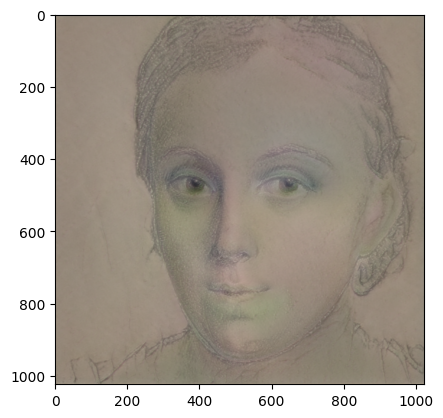

In [ ]:
projected_w='/content/drive/MyDrive/StyleGAN/out/rose2/projected_w1.npz'

ws = np.load(projected_w)['w']
ws = torch.tensor(ws, device=device) # pylint: disable=not-callable
assert ws.shape[1:] == (G.num_ws, G.w_dim)
for idx, w in enumerate(ws):
    img = G.synthesis(w.unsqueeze(0), noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img=img.to('cpu')
    plt.imshow(img[0])

## Network blending

In [172]:
with open(model_list[0], 'rb') as f:
    G1 = pickle.load(f)['G_ema'].requires_grad_(False).to(device)#.cuda()  # torch.nn.Module ##FFHQ model
    
with open(model_list[1], 'rb') as f:
    G2 = pickle.load(f)['G_ema'].requires_grad_(False).to(device)#.cuda()  # torch.nn.Module ##metfaces model

In [ ]:
'''steady_list=[]
for key in list(G1.state_dict().keys()):
  boolean=G1.state_dict()[key]==G2.state_dict()[key]
  boolean=boolean.to('cpu').numpy()
  if False not in np.unique(boolean):
    if key.split('.')[-1] not in steady_list:
      steady_list.append(key.split('.')[-1])

print(steady_list)'''
##전이학습을 해도 parameter값이 동일한 network
##resample_filter : upsample in G
## noise_const : noise after each convolution

['resample_filter', 'noise_const']


In [173]:
def get_conv_names(model,max_dim):
    val = 1 + int(np.log2(max_dim / 4))  # 9 for 1024, 8 for 512
    resolutions = [4 * 2 ** x for x in range(val)]
    names = [x[0] for x in list(model.named_parameters())] #fine tuned networks
    level_names = [["conv0", "const"],["conv1", "torgb"]]
    position=0
    conv_names=[]
    for res in resolutions:
        rootname = f"synthesis.b{res}."
        for level, level_suffixes in enumerate(level_names): #conv0,const -> level 1 // conv1,torgb -> level 2
            for suffix in level_suffixes:
                searchname = rootname+suffix
                matches = [x for x in names if x.startswith(searchname)]
                info_tuples = [(name, f"b{res}",level,position) for name in matches]
                conv_names.extend(info_tuples)
            position+=1
    return conv_names

In [174]:
def blend(G1, G2, resolution, level, network_size=1024, blend_width=None, verbose=True):

  model1_names=get_conv_names(G1,1024)
  model2_names=get_conv_names(G2,1024)

  assert model1_names==model2_names

  output_model = copy.deepcopy(G1)

  short_names = [(x[1:3]) for x in model1_names]
  full_names = [(x[0]) for x in model1_names]
  mid_point_idx = short_names.index((f'b{resolution}', level))
  mid_point_pos = model1_names[mid_point_idx][3]

  ys=[]
  for name, resolution, level, position in model1_names:
    x = position - mid_point_pos 
    if blend_width: #blend_width = None : hard blend / = float : soft blend(logistic)
        exponent = -x/blend_width #blend_width 작을수록 G2영향력 증가 
        y = 1 / (1 + math.exp(exponent))
    else:
        y = 1 if x > 1 else 0
    ys.append(y)
    if verbose:
        print(f"Blending {name} by {y}")
  #position이 mid_point보다 클수록 exponent 작아짐 -> y가 커짐 -> G2의 영향력 증가 = mid_point기준으로 해상도 큰 부분 G2로 & 해상도 작은 부분 G1으로
  new_model_state_dict = output_model.state_dict()
  for name, y in zip(full_names,ys):
    new_model_state_dict[name] = G2.state_dict()[name]*y+G1.state_dict()[name]*(1-y)

  output_model.load_state_dict(new_model_state_dict)

  return output_model

In [175]:
def get_image(model, z=None, label=0, truncation_psi=0.7, noise_mode="const", w=None, is_w=False):
    if is_w:
        img = model.synthesis(w.unsqueeze(0), noise_mode=noise_mode)
    else:
        img = model(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    imgfile = PIL.Image.fromarray(img[0].cpu().numpy(), "RGB")

    return imgfile

In [176]:
resolutions=[4, 8, 16, 32, 64, 128, 256, 512, 1024]

blended_models={}
for resolution in resolutions:
  blended_models[f'b{resolution}']=blend(G1,G2,resolution,level=0,network_size=1024,blend_width=0.5,verbose=True)

Blending synthesis.b4.const by 0.5
Blending synthesis.b4.conv1.weight by 0.8807970779778823
Blending synthesis.b4.conv1.noise_strength by 0.8807970779778823
Blending synthesis.b4.conv1.bias by 0.8807970779778823
Blending synthesis.b4.conv1.affine.weight by 0.8807970779778823
Blending synthesis.b4.conv1.affine.bias by 0.8807970779778823
Blending synthesis.b4.torgb.weight by 0.8807970779778823
Blending synthesis.b4.torgb.bias by 0.8807970779778823
Blending synthesis.b4.torgb.affine.weight by 0.8807970779778823
Blending synthesis.b4.torgb.affine.bias by 0.8807970779778823
Blending synthesis.b8.conv0.weight by 0.9820137900379085
Blending synthesis.b8.conv0.noise_strength by 0.9820137900379085
Blending synthesis.b8.conv0.bias by 0.9820137900379085
Blending synthesis.b8.conv0.affine.weight by 0.9820137900379085
Blending synthesis.b8.conv0.affine.bias by 0.9820137900379085
Blending synthesis.b8.conv1.weight by 0.9975273768433653
Blending synthesis.b8.conv1.noise_strength by 0.9975273768433653

In [177]:
path=pathlib.Path('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out')
img_dir=list(path.glob('*'))
img_dir=img_dir[1:]
img_dir

[PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/rose1'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/rose2'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/monalisa'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/IU'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/Venus'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/chaeunwoo'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/myungsoo'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/macron')]

In [178]:
mapped_type='w18_5000'
for dir in img_dir[1:2]:
  projected_w=list(dir.glob('*{}.npz'.format(mapped_type)))
  if len(projected_w)!=0:
    ws = np.load(projected_w[0])['w']
    ws = torch.tensor(ws, device=device)
    fig,axes=plt.subplots(3,3,figsize=(15,15))
    for ax,model in zip(axes.ravel(),blended_models):
      m=blended_models[model]
      assert ws.shape[1:] == (m.num_ws, m.w_dim)
      img=get_image(model=blended_models[model],w=ws[0],is_w=True)
      ax.imshow(img)
      ax.set_title(f'{model} blended_model')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [179]:
c=None
m=blended_models['b64']
for _ in range(10):
  z = torch.randn([1, G.z_dim],device=device)
  ws = G.mapping(z,c,truncation_psi=0.5, truncation_cutoff=8)
  img_ori = G.synthesis(ws, noise_mode='const', force_fp32=True)
  assert ws.shape[1:] == (m.num_ws, m.w_dim)
  img_trans=get_image(model=m,w=ws[0],is_w=True)
  fig,axes=plt.subplots(1,2,figsize=(10,5))
  #img_trans=img_trans.to('cpu')
  img_ori=img_ori.to('cpu')
  axes[0].imshow(img_ori[0].permute(1,2,0))
  axes[1].imshow(img_trans)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [180]:
c=None
m=blended_models['b128']
for _ in range(10):
  z = torch.randn([1, G.z_dim],device=device)
  ws = G.mapping(z,c,truncation_psi=0.5, truncation_cutoff=8)
  img_ori = G.synthesis(ws, noise_mode='const', force_fp32=True)
  assert ws.shape[1:] == (m.num_ws, m.w_dim)
  img_trans=get_image(model=m,w=ws[0],is_w=True)
  fig,axes=plt.subplots(1,2,figsize=(10,5))
  #img_trans=img_trans.to('cpu')
  img_ori=img_ori.to('cpu')
  axes[0].imshow(img_ori[0].permute(1,2,0))
  axes[1].imshow(img_trans)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.